In [1]:
!git clone https://github.com/andreofner/pyGPC

Cloning into 'pyGPC'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 108 (delta 12), reused 33 (delta 10), pack-reused 72
Receiving objects: 100% (108/108), 93.78 KiB | 1.19 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [6]:
cd pyGPC

/content/pyGPC


In [9]:
!python GPC.py

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2760704/45929032 bytes (6.0%)5701632/45929032 bytes (12.4%)8626176/45929032 bytes (18.8%)11640832/45929032 bytes (25.3%)14508032/45929032 bytes (31.6%)16916480/45929032 bytes (36.8%)19652608/45929032 bytes (42.8%)22495232/45929032 bytes (49.0%)25329664/45929032 bytes (55.1%)28237824/45929032 bytes (61.5%)30998528/45929032 bytes (67.5%)33619968/45929032 bytes (73.2%)

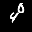

Inputs




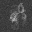

Hierarchical prediction



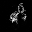

Dynamical prediction



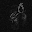

Hierarchical prediction error



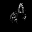

Dynamical prediction error



In [11]:
from IPython.display import Image, display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
Image(open('./figures/inputs.gif','rb').read())
print("Inputs\n\n")
Image(open('./figures/hier_predictions.gif','rb').read())
print("Hierarchical prediction\n")
Image(open('./figures/trans_predictions.gif','rb').read())
print("Dynamical prediction\n")

Image(open('./figures/hier_errors.gif','rb').read())
print("Hierarchical prediction error\n")
Image(open('./figures/trans_errors.gif','rb').read())
print("Dynamical prediction error\n")